#DSCI 417 – Project 02
##Student Grade Database
**Adam Sneed**

##Part A: Set up Environment
In this part of the project, we will set up our environment.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, count, round, udf, sum, when
from pyspark.sql.types import DoubleType, FloatType, StringType, IntegerType
spark = SparkSession.builder.getOrCreate()

##Part B: Load the Data
We will begin this section by loading in each data file into a spark DataFrame.

In [0]:

accepted_schema = 'acc_term_id STRING, sid INT, first_name STRING, last_name STRING, major STRING'
alumni_schema = 'sid INT'
expelled_schema = 'sid INT'
unretained_schema = 'sid INT'
faculty_schema = 'fid INT, first_name STRING, last_name STRING, dept STRING'
courses_schema = 'dept STRING, course STRING, prereq STRING, credits INT'
grades_schema = 'term_id STRING, course STRING, sid INT, fid INT, grade STRING'

alumni = spark.read.option('delimiter', ',').\
    csv('/FileStore/tables/univ/alumni.csv', header='True', schema=alumni_schema)

courses = spark.read.option('delimiter', ',').\
    csv('/FileStore/tables/univ/courses.csv', header='True', schema=courses_schema)

expelled = spark.read.option('delimiter', ',').\
    csv('/FileStore/tables/univ/expelled.csv', header='True', schema=expelled_schema)

faculty = spark.read.option('delimiter', ',').\
    csv('/FileStore/tables/univ/faculty.csv', header='True', schema=faculty_schema)

grades = spark.read.option('delimiter', ',').\
    csv('/FileStore/tables/univ/grades.csv', header='True', schema=grades_schema)

accepted = spark.read.option('delimiter', ',').\
    csv('/FileStore/tables/univ/accepted.csv', header='True', schema=accepted_schema)

unretained = spark.read.option('delimiter', ',').\
    csv('/FileStore/tables/univ/unretained.csv', header='True', schema=unretained_schema)

Next, we will print the number of records in each DataFrame.

In [0]:
print("Number of records in 'accepted' DataFrame:", accepted.count())
print("Number of records in 'alumni' DataFrame:", alumni.count())
print("Number of records in 'expelled' DataFrame:", expelled.count())
print("Number of records in 'unretained' DataFrame:", unretained.count())
print("Number of records in 'faculty' DataFrame:", faculty.count())
print("Number of records in 'courses' DataFrame:", courses.count())
print("Number of records in 'grades' DataFrame:", grades.count())

Number of records in 'accepted' DataFrame: 12207
Number of records in 'alumni' DataFrame: 4920
Number of records in 'expelled' DataFrame: 403
Number of records in 'unretained' DataFrame: 2289
Number of records in 'faculty' DataFrame: 330
Number of records in 'courses' DataFrame: 119
Number of records in 'grades' DataFrame: 285137


##Part C: Student Count by Status
In this part, we will count the number of students in each of the following groups: students who have been
accepted, students who actually enrolled in courses, current students, all former students, alumni, unretained
students, and students who were expelled.


We will now create a three new DataFrames to store student info for students in various categories. We will
then generate the desired counts.

In [0]:
enrolled = accepted.join(grades, accepted.sid == grades.sid, "inner")

current = enrolled.join(alumni, ["sid"], "leftanti") \
                 .join(unretained, ["sid"], "leftanti") \
                 .join(expelled, ["sid"], "leftanti")

former = enrolled.join(current, ["sid"], "leftanti")

print("Number of accepted students:", accepted.count())
print("Number of enrolled students:", enrolled.count())
print("Number of current students:", current.count())
print("Number of former students:", former.count())
print("Number of unretained students:", unretained.count())
print("Number of expelled students:", expelled.count())
print("Number of alumni:", alumni.count())

Number of accepted students: 12207
Number of enrolled students: 285137
Number of current students: 41576
Number of former students: 243561
Number of unretained students: 2289
Number of expelled students: 403
Number of alumni: 4920


##Part D: Distribution of Students by Major
In this part, we will determine of the number of students currently in each major, as well as the proportion of
the overall number of students in each major.

In [0]:
total_current_students = current.count()

result = (
    current
    .groupBy("major")
    .agg(
        count("*").alias("n_students"),
        (count("*") / total_current_students).alias("prop")
    )
    .orderBy(col("prop").desc())
)

result.show()

+-----+----------+-------------------+
|major|n_students|               prop|
+-----+----------+-------------------+
|  BIO|     12143| 0.2920675389647874|
|  CSC|     10377|0.24959111025591688|
|  CHM|      8162|0.19631518183567442|
|  MTH|      6583| 0.1583365403117183|
|  PHY|      4311|0.10368962863190302|
+-----+----------+-------------------+



##Part E: Course Enrollments by Department
In this part, we will determine of the number of students enrolled in courses offered by each department during
the Spring 2021 term.

In [0]:
sp21_enr = grades.filter(col("term_id") == "2021A").count()

result = (
    grades.filter(col("term_id") == "2021A")
    .join(courses, "course", "inner")
    .groupBy("dept")
    .agg(
        count("*").alias("n_students"),
        (count("*") / sp21_enr).alias("prop")
    )
    .withColumn("prop", round(col("prop"), 4))
    .orderBy(col("prop").desc())
)

result.show()

+----+----------+------+
|dept|n_students|  prop|
+----+----------+------+
| GEN|      5142|0.4198|
| BIO|      1786|0.1458|
| MTH|      1517|0.1238|
| CHM|      1512|0.1234|
| CSC|      1479|0.1207|
| PHY|       814|0.0664|
+----+----------+------+



##Part F: Graduation Rates by Major
In this part, we will determine the graduation rates for each major. First,
we will create a DataFrame containing the number of former students in each major. 

In [0]:
former_major_count = former.groupBy("major").count().withColumnRenamed("count", "n_former")

former_by_major = former_major_count.orderBy("major")

former_by_major.show()

+-----+--------+
|major|n_former|
+-----+--------+
|  BIO|   72160|
|  CHM|   48907|
|  CSC|   61890|
|  MTH|   36555|
|  PHY|   24049|
+-----+--------+



We will now determine the number of alumni for each major.

In [0]:
alumni_former = former.join(alumni, on="sid", how="inner")

alumni_major_count = alumni_former.groupBy("major").count().withColumnRenamed("count", "n_alumni")

alumni_by_major = alumni_major_count.orderBy("major")

alumni_by_major.show()

+-----+--------+
|major|n_alumni|
+-----+--------+
|  BIO|   62175|
|  CHM|   42825|
|  CSC|   52896|
|  MTH|   31096|
|  PHY|   20140|
+-----+--------+



In [0]:
combined_major_stats = former_by_major.join(alumni_by_major, on="major", how="full_outer")

combined_major_stats = combined_major_stats.fillna(0)

combined_major_stats = combined_major_stats.withColumn(
    "grad_rate",
    round(col("n_alumni") / col("n_former"), 4)
)

combined_major_stats = combined_major_stats.select("major", "n_alumni", "n_former", "grad_rate").orderBy("major")


combined_major_stats.show()

+-----+--------+--------+---------+
|major|n_alumni|n_former|grad_rate|
+-----+--------+--------+---------+
|  BIO|   62175|   72160|   0.8616|
|  CHM|   42825|   48907|   0.8756|
|  CSC|   52896|   61890|   0.8547|
|  MTH|   31096|   36555|   0.8507|
|  PHY|   20140|   24049|   0.8375|
+-----+--------+--------+---------+



##Part G: Number of Terms Required for Graduation
In this part, we will find a frequency distribution for the number of terms that alumni required for graduation,

In [0]:
(
    grades
    .join(alumni, on="sid", how="inner")
    .groupBy("sid")
    .agg(count("term_id").alias("n_terms"))
    .groupBy("n_terms")
    .agg(count("*").alias("n_alumni"))
    .orderBy("n_terms")
    .show()
)

+-------+--------+
|n_terms|n_alumni|
+-------+--------+
|     38|     332|
|     39|     667|
|     40|     818|
|     41|     837|
|     42|     686|
|     43|     450|
|     44|     263|
|     45|     166|
|     46|     140|
|     47|      87|
|     48|      83|
|     49|      55|
|     50|      49|
|     51|      38|
|     52|      29|
|     53|      27|
|     54|      27|
|     55|      24|
|     56|      18|
|     57|      16|
+-------+--------+
only showing top 20 rows



##Part H: Current Student GPA
In this section, we will calculate the GPA of each current student at SU and will analyze the results. We will start by converting the letter grades into number grades.

In [0]:
def convert_grade(grade):
    grade_mapping = {'A': 4, 'B': 3, 'C': 2, 'D': 1, 'F': 0}
    return grade_mapping[grade]

We will now calculate the GPA of each student currently enrolled at SU.

In [0]:
current_gpa = (
    grades.join(courses.select("course", "credits"), grades.course == courses.course)
    .withColumn("num_grade", convert_grade_udf(col("grade")))
    .withColumn("gp", col("num_grade") * col("credits"))
    .groupBy("sid")
    .agg(
        round((sum(col("gp")) / sum(col("credits"))), 2).alias("gpa")
    )
    .join(current, on='sid', how='outer')
    .sort("gpa", ascending = False)
)

current_gpa.show(10)

+------+---+-----------+----------+---------+-----+-------+------+----+----+-----+
|   sid|gpa|acc_term_id|first_name|last_name|major|term_id|course| sid| fid|grade|
+------+---+-----------+----------+---------+-----+-------+------+----+----+-----+
|100523|4.0|       null|      null|     null| null|   null|  null|null|null| null|
|101011|4.0|       null|      null|     null| null|   null|  null|null|null| null|
|100058|4.0|       null|      null|     null| null|   null|  null|null|null| null|
|100951|4.0|       null|      null|     null| null|   null|  null|null|null| null|
|100255|4.0|       null|      null|     null| null|   null|  null|null|null| null|
|100202|4.0|       null|      null|     null| null|   null|  null|null|null| null|
|100630|4.0|       null|      null|     null| null|   null|  null|null|null| null|
|100373|4.0|       null|      null|     null| null|   null|  null|null|null| null|
|100640|4.0|       null|      null|     null| null|   null|  null|null|null| null|
|100

We will now determine the number of current students with perfect 4.0 GPAs.

In [0]:
perfect_gpa_count = current_gpa.filter(col("gpa") == 4.0).count()

print("Number of current students with a perfect 4.0 GPA:", perfect_gpa_count)

Number of current students with a perfect 4.0 GPA: 1766


Next, we will create a histogram displaying the distribution of GPAs for current students.

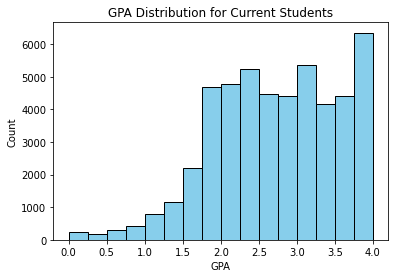

In [0]:
current_gpa_pd = current_gpa.toPandas()

bins = [i * 0.25 for i in range(17)]
color = 'skyblue'

plt.hist(current_gpa_pd['gpa'], bins=bins, color=color, edgecolor='black')

plt.title('GPA Distribution for Current Students')
plt.xlabel('GPA')
plt.ylabel('Count')

plt.show()

##Part I: Grade Distribution by Instructor
In this part, we will determine the proportion of A, B, C, D, and F grades given out by each faculty member at SU. We will start by determining the distribution of the grades awarded by each faculty member.

In [0]:
grouped_grades = grades.groupBy("fid")

faculty_grade_dist = grouped_grades.agg(
    count(when(col("grade") == "A", True)).alias("countA"),
    count(when(col("grade") == "B", True)).alias("countB"),
    count(when(col("grade") == "C", True)).alias("countC"),
    count(when(col("grade") == "D", True)).alias("countD"),
    count(when(col("grade") == "F", True)).alias("countF"),
    count("*").alias("N")
)

faculty_grade_dist = faculty_grade_dist.join(faculty, on="fid", how="inner")

prop_columns = ["propA", "propB", "propC", "propD", "propF"]
for col_name in prop_columns:
    faculty_grade_dist = faculty_grade_dist.withColumn(
        col_name,
        round(col(f"count{col_name[-1]}") / col("N"), 2)
    )

faculty_grade_dist = faculty_grade_dist.select("fid", "first_name", "last_name", "dept", "N", *prop_columns)

faculty_grade_dist.show(5)

+----+----------+---------+----+----+-----+-----+-----+-----+-----+
| fid|first_name|last_name|dept|   N|propA|propB|propC|propD|propF|
+----+----------+---------+----+----+-----+-----+-----+-----+-----+
|1088| Stephanie| Williams| MTH|1666| 0.17| 0.32| 0.36| 0.13| 0.01|
|1238|    Willie|    Black| BIO| 682| 0.48| 0.33| 0.15| 0.04| 0.01|
|1829|     Bobby|   Wilson| GEN| 640| 0.13| 0.26| 0.37|  0.2| 0.04|
|2122|  Jennifer|   Porter| GEN| 825| 0.12| 0.29| 0.33| 0.21| 0.05|
|1591|    Amanda| Mitchell| CHM| 395| 0.09| 0.29| 0.35| 0.18| 0.08|
+----+----------+---------+----+----+-----+-----+-----+-----+-----+
only showing top 5 rows



We will now identify the 10 faculty members who assign the fewest A grades. 

In [0]:
filtered_faculty_grade_dist = faculty_grade_dist.filter(col('N') >= 100)

sorted_filtered_faculty_grade_dist = filtered_faculty_grade_dist.orderBy('propA')

sorted_filtered_faculty_grade_dist.show(10)

+----+----------+---------+----+---+-----+-----+-----+-----+-----+
| fid|first_name|last_name|dept|  N|propA|propB|propC|propD|propF|
+----+----------+---------+----+---+-----+-----+-----+-----+-----+
|1628|   Rebecca|  Stewart| GEN|395| 0.03|  0.2| 0.37| 0.28| 0.12|
|1481|   Abigail|   Brooks| BIO|311| 0.05| 0.23| 0.37| 0.28| 0.08|
|3187|    Joshua|  Griffin| GEN|154| 0.05| 0.24| 0.38| 0.21| 0.12|
|1039|      Joan|      Lee| BIO|147| 0.07| 0.24| 0.31| 0.33| 0.05|
|1264|     Carol|   Martin| CSC|302| 0.07| 0.22| 0.34| 0.25| 0.13|
|1479|     Karen|  Simmons| GEN|310| 0.08| 0.31|  0.3| 0.21|  0.1|
|1591|    Amanda| Mitchell| CHM|395| 0.09| 0.29| 0.35| 0.18| 0.08|
|1212|   Michael| Martinez| MTH|775| 0.09| 0.23| 0.31| 0.27| 0.11|
|1462|     Ralph|    Perez| BIO|195| 0.09| 0.21| 0.39| 0.23| 0.09|
|2925|   Cynthia|    Lewis| GEN|302| 0.09| 0.22| 0.35| 0.25| 0.09|
+----+----------+---------+----+---+-----+-----+-----+-----+-----+
only showing top 10 rows



We will now identify the 10 faculty members who award A’s most frequently.

In [0]:
filtered_faculty_grade_dist = faculty_grade_dist.filter(col('N') >= 100)

sorted_filtered_faculty_grade_dist = filtered_faculty_grade_dist.orderBy(col('propA').desc())

sorted_filtered_faculty_grade_dist.show(10)

+----+----------+---------+----+----+-----+-----+-----+-----+-----+
| fid|first_name|last_name|dept|   N|propA|propB|propC|propD|propF|
+----+----------+---------+----+----+-----+-----+-----+-----+-----+
|1092|    Hannah|   Morgan| GEN|1953| 0.59|  0.3| 0.09| 0.01|  0.0|
|1262|      Sara|   Hunter| GEN|2266| 0.57| 0.28| 0.12| 0.02|  0.0|
|1094|      Judy|Patterson| GEN|1904| 0.55| 0.32| 0.12| 0.02|  0.0|
|1548|    Donald|   Gibson| GEN|1478| 0.55| 0.27| 0.14| 0.03| 0.01|
|1484|     Billy|   Cooper| BIO| 434| 0.54| 0.33| 0.09| 0.04| 0.01|
|1058|      John|  Simpson| GEN|2729| 0.53| 0.33| 0.12| 0.02|  0.0|
|1328|     David|   Parker| GEN|1543| 0.53| 0.28| 0.14| 0.04| 0.01|
|1038|   Theresa|  Stevens| CHM| 233| 0.52| 0.31| 0.15| 0.02| 0.01|
|1291|     Joyce|   Butler| GEN|2212| 0.51| 0.31| 0.14| 0.03| 0.01|
|1305|     Betty|  Stewart| GEN|2081| 0.51| 0.31| 0.14| 0.04| 0.01|
+----+----------+---------+----+----+-----+-----+-----+-----+-----+
only showing top 10 rows

